## Import Libraries

In [8]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

## Import Dataset

In [116]:
amazon_review_data = pd.read_csv('./data.csv')

amazon_review_data.head()

overall  verified   reviewTime      reviewerID        asin style/Style:  \
0        5      True  08 22, 2013  A34A1UP40713F8  B00009W3I4   Dryer Vent   
1        5      True   02 8, 2016  A1AHW6I678O6F2  B00009W3PA          NaN   
2        5      True   08 5, 2015   A8R48NKTGCJDQ  B00009W3PA          NaN   
3        5      True  04 24, 2015   AR3OHHHW01A8E  B00009W3PA          NaN   
4        5      True  03 21, 2015  A2CIEGHZ7L1WWR  B00009W3PA          NaN   

      reviewerName                                         reviewText  \
0    James. Backus  I like this as a vent as well as something tha...   
1           kevin.                                          good item   
2        CDBrannom                     Fit my new LG dryer perfectly.   
3  Calvin E Reames                     Good value for electric dryers   
4   albert j. kong                  Price and delivery was excellent.   

         summary  unixReviewTime  ... image/1 image/2 image/3 image/4 image/5  \
0  Great product      1377129600  ...     NaN     NaN     NaN     NaN     NaN   
1     Five Stars      1454889600  ...     NaN     NaN     NaN     NaN     NaN   
2     Five Stars      1438732800  ...     NaN     NaN     NaN     NaN     NaN   
3   Perfect size      1429833600  ...     NaN     NaN     NaN     NaN     NaN   
4     Five Stars      1426896000  ...     NaN     NaN     NaN     NaN     NaN   

  image/6 image/7 style/Size Name: style/Style Name: style/Package Quantity:  
0     NaN     NaN              NaN               NaN                     NaN  
1     NaN     NaN              NaN               NaN                     NaN  
2     NaN     NaN              NaN               NaN                     NaN  
3     NaN     NaN              NaN               NaN                     NaN  
4     NaN     NaN              NaN               NaN                     NaN  

[5 rows x 24 columns]

## Remove unnecessary columns

In [117]:
#Creating a copy
process_reviews=amazon_review_data.copy()

#Remove unnecessary columns
process_reviews = process_reviews.drop('verified', axis=1)
process_reviews = process_reviews.drop('reviewerID', axis=1)
process_reviews = process_reviews.drop('reviewTime', axis=1)
process_reviews = process_reviews.drop('asin', axis=1)
process_reviews = process_reviews.drop('reviewerName', axis=1)
process_reviews = process_reviews.drop('style/Size:', axis=1)
process_reviews = process_reviews.drop('style/Style:', axis=1)
process_reviews = process_reviews.drop('style/Size Name:', axis=1)
process_reviews = process_reviews.drop('style/Color:', axis=1)
process_reviews = process_reviews.drop('style/Style Name:', axis=1)
process_reviews = process_reviews.drop('style/Package Quantity:', axis=1)
process_reviews = process_reviews.drop('vote', axis=1)
process_reviews = process_reviews.drop('image/0', axis=1)
process_reviews = process_reviews.drop('image/1', axis=1)
process_reviews = process_reviews.drop('image/2', axis=1)
process_reviews = process_reviews.drop('image/3', axis=1)
process_reviews = process_reviews.drop('image/4', axis=1)
process_reviews = process_reviews.drop('image/5', axis=1)
process_reviews = process_reviews.drop('image/6', axis=1)
process_reviews = process_reviews.drop('image/7', axis=1)

process_reviews.head()

overall                                         reviewText        summary  \
0        5  I like this as a vent as well as something tha...  Great product   
1        5                                          good item     Five Stars   
2        5                     Fit my new LG dryer perfectly.     Five Stars   
3        5                     Good value for electric dryers   Perfect size   
4        5                  Price and delivery was excellent.     Five Stars   

   unixReviewTime  
0      1377129600  
1      1454889600  
2      1438732800  
3      1429833600  
4      1426896000

In [118]:
#Checking for null values
process_reviews.isnull().sum()

overall           0
reviewText        0
summary           0
unixReviewTime    0
dtype: int64

In [119]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

## Concatenating review text and summary

In [120]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

overall  unixReviewTime                                            reviews
0        5      1377129600  I like this as a vent as well as something tha...
1        5      1454889600                                good itemFive Stars
2        5      1438732800           Fit my new LG dryer perfectly.Five Stars
3        5      1429833600         Good value for electric dryersPerfect size
4        5      1426896000        Price and delivery was excellent.Five Stars

## Creating 'sentiment' column

In [121]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] > 0.0 and row['overall'] <= 2.0:
        val = 'Negative'
    elif row['overall'] > 2.0 and row['overall'] < 3.0:
        val = 'Neutral-Negative'
    elif row['overall'] > 3.0 and row['overall'] <= 4.0:
        val = 'Neutral-Positive'
    elif row['overall'] > 4.0 and row['overall'] <= 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [122]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head(10)

overall  unixReviewTime                                            reviews  \
0        5      1377129600  I like this as a vent as well as something tha...   
1        5      1454889600                                good itemFive Stars   
2        5      1438732800           Fit my new LG dryer perfectly.Five Stars   
3        5      1429833600         Good value for electric dryersPerfect size   
4        5      1426896000        Price and delivery was excellent.Five Stars   
5        5      1388016000  I purchasaed a new dryer and did not want to r...   
6        4      1470096000               Good value.Good value for the price.   
7        2      1499299200  works great. we loved ours! till we didn't.  t...   
8        2      1499299200  Luved it for the few months it worked!  great ...   
9        1      1415923200  Be careful, NewAir will not stand by their pro...   

          sentiment  
0          Positive  
1          Positive  
2          Positive  
3          Positive  
4          Positive  
5          Positive  
6  Neutral-Positive  
7          Negative  
8          Negative  
9          Negative

In [123]:
process_reviews['sentiment'].value_counts()

Positive            1612
Neutral              421
Neutral-Positive     222
Negative              22
Name: sentiment, dtype: int64

## Review text-Punctuation Cleaning

In [124]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [125]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

overall  unixReviewTime                                            reviews  \
0        5      1377129600  i like this as a vent as well as something tha...   
1        5      1454889600                                good itemfive stars   
2        5      1438732800            fit my new lg dryer perfectlyfive stars   
3        5      1429833600         good value for electric dryersperfect size   
4        5      1426896000         price and delivery was excellentfive stars   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

## Review text-Stop words

In [126]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [127]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

overall  unixReviewTime                                            reviews  \
0        5      1377129600  like vent well something will keep house warme...   
1        5      1454889600                                good itemfive stars   
2        5      1438732800               fit new lg dryer perfectlyfive stars   
3        5      1429833600             good value electric dryersperfect size   
4        5      1426896000                 price delivery excellentfive stars   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

## More features for text analysis

Polarity: We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity

Review length: length of the review which includes each letters and spaces

Word length: This measures how many words are there in review

In [128]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [130]:
process_reviews.head(10)

overall  unixReviewTime                                            reviews  \
0        5      1377129600  like vent well something will keep house warme...   
1        5      1454889600                                good itemfive stars   
2        5      1438732800               fit new lg dryer perfectlyfive stars   
3        5      1429833600             good value electric dryersperfect size   
4        5      1426896000                 price delivery excellentfive stars   
5        5      1388016000  purchasaed new dryer not want reuse cord old u...   
6        4      1470096000                         good valuegood value price   
7        2      1499299200  works great loved till didnt not last buy warr...   
8        2      1499299200  luved months worked great little bullet shaped...   
9        1      1415923200  careful newair will not stand products newair ...   

          sentiment  polarity  review_len  word_count  
0          Positive  0.000000         106          16  
1          Positive  0.700000          19           3  
2          Positive  0.268182          36           6  
3          Positive  0.700000          38           5  
4          Positive  0.000000          34           4  
5          Positive  0.117273         137          20  
6  Neutral-Positive  0.700000          26           4  
7          Negative  0.247273         139          23  
8          Negative  0.124811         303          50  
9          Negative  0.117095        2663         375

In [131]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Sentiment polarity distribution

In [132]:
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity')

## Review Rating Distribution

In [133]:
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating')

## Review Text Length Distribution

In [134]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

## Review Text Word Count Distribution

In [135]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

## N-gram analysis

## Monogram analysis

In [136]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu_pos = process_reviews[process_reviews["sentiment"]=='Neutral-Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neu_neg = process_reviews[process_reviews["sentiment"]=='Neutral-Negative'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from neutral positive reviews ##
freq_dict = defaultdict(int)
for sent in review_neu_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'blue')


## Get the bar chart from neutral negative reviews ##
if not review_neu_neg.empty:
    freq_dict = defaultdict(int)
    for sent in review_neu_neg["reviews"]:
        for word in generate_ngrams(sent):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace3 = horizontal_bar_chart(fd_sorted.head(25), 'black')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace4 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=5, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral-positive reviews","Frequent words of neutral reviews","Frequent words of neutral-negative reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
if not review_neu_neg.empty:
    fig.append_trace(trace3, 4, 1)
fig.append_trace(trace4, 5, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

## Bigram analysis

In [137]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from neutral positive reviews ##
freq_dict = defaultdict(int)
for sent in review_neu_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace3 = horizontal_bar_chart(fd_sorted.head(25), 'blue')


## Get the bar chart from neutral negative reviews ##
if not review_neu_neg.empty:
    freq_dict = defaultdict(int)
    for sent in review_neu_neg["reviews"]:
        for word in generate_ngrams(sent,2):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace4 = horizontal_bar_chart(fd_sorted.head(25), 'black')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=5, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews",
                                           "Bigram plots of Neutral-Positive reviews",
                                            "Bigram plots of Neutral-Negative reviews",
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig.append_trace(trace3, 4, 1)
if not review_neu_neg.empty:
    fig.append_trace(trace4, 5, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

## Trigram analysis

In [138]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

## Get the bar chart from neutral positive reviews ##
freq_dict = defaultdict(int)
for sent in review_neu_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace3 = horizontal_bar_chart(fd_sorted.head(25), 'blue')


## Get the bar chart from neutral negative reviews ##
if not review_neu_neg.empty:
    freq_dict = defaultdict(int)
    for sent in review_neu_neg["reviews"]:
        for word in generate_ngrams(sent,3):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace4 = horizontal_bar_chart(fd_sorted.head(25), 'black')





# Creating two subplots
fig = tools.make_subplots(rows=5, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews",
                                          "Tri-gram plots of Neutral-Positive reviews",
                                          "Tri-gram plots of Neutral-Negative reviews",
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig.append_trace(trace3, 4, 1)
if not review_neu_neg.empty:
    fig.append_trace(trace4, 5, 1)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

## Wordcloud-Positive reviews

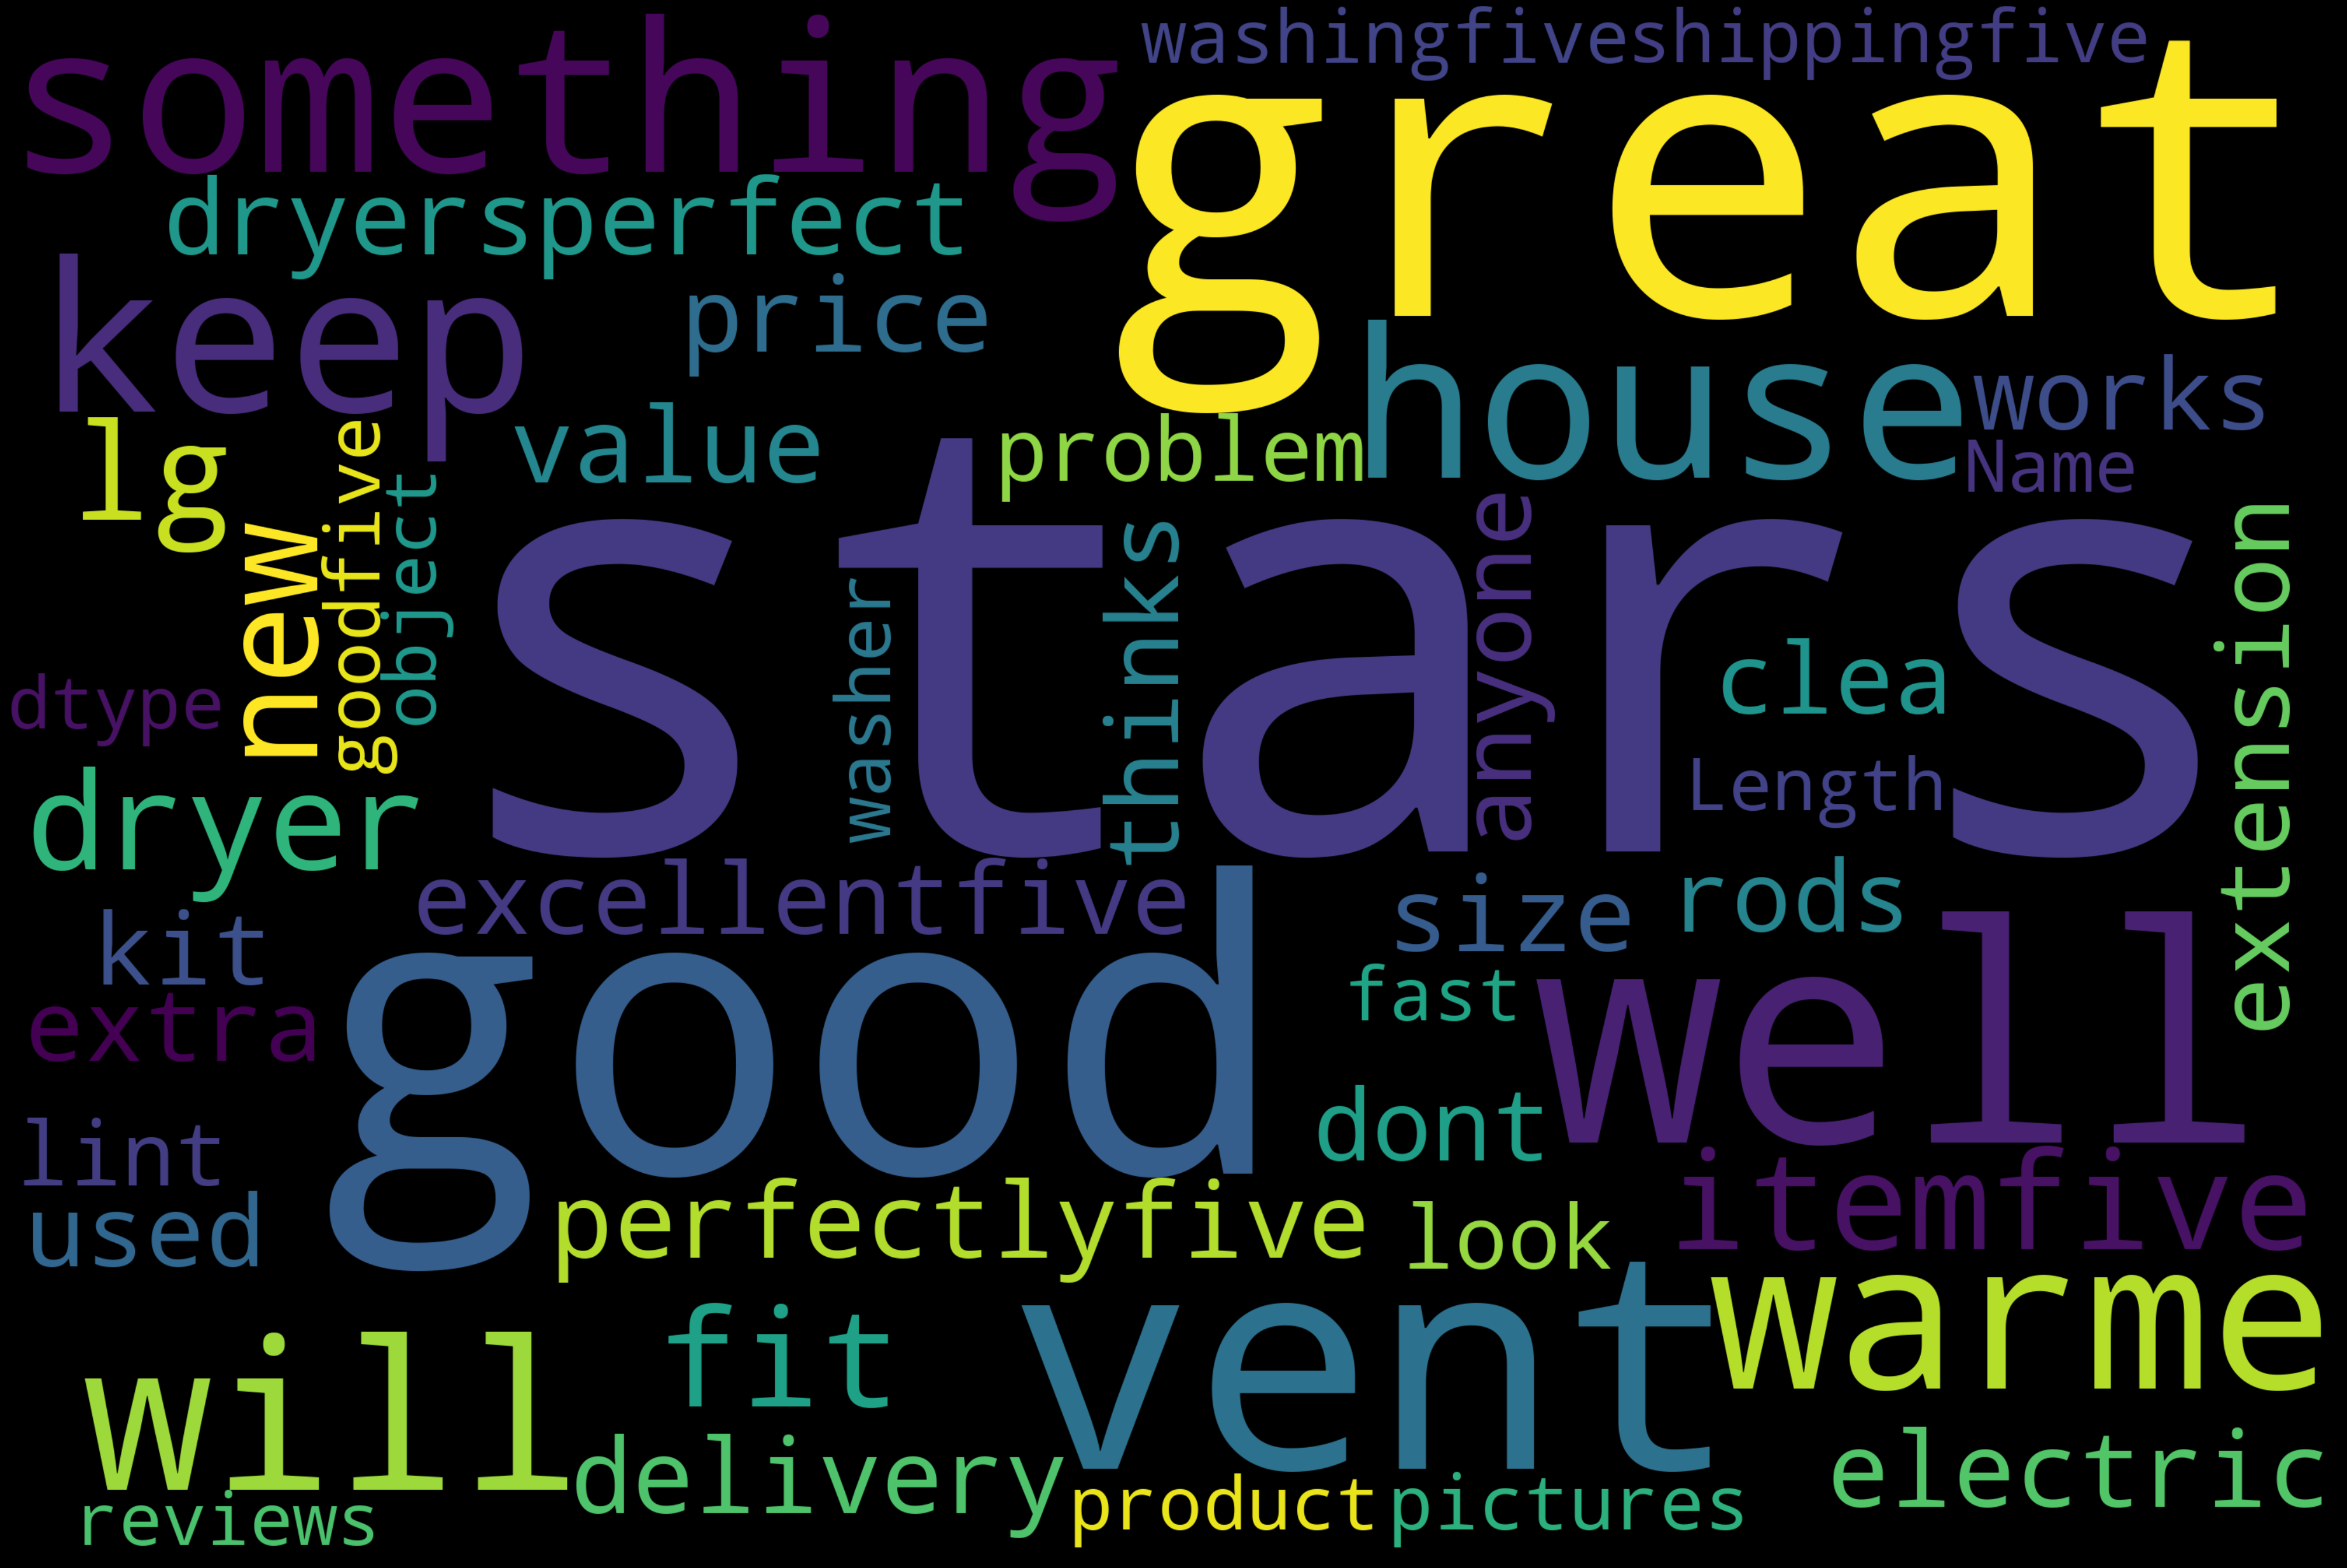

In [139]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Wordcloud-Neutral-Positive reviews

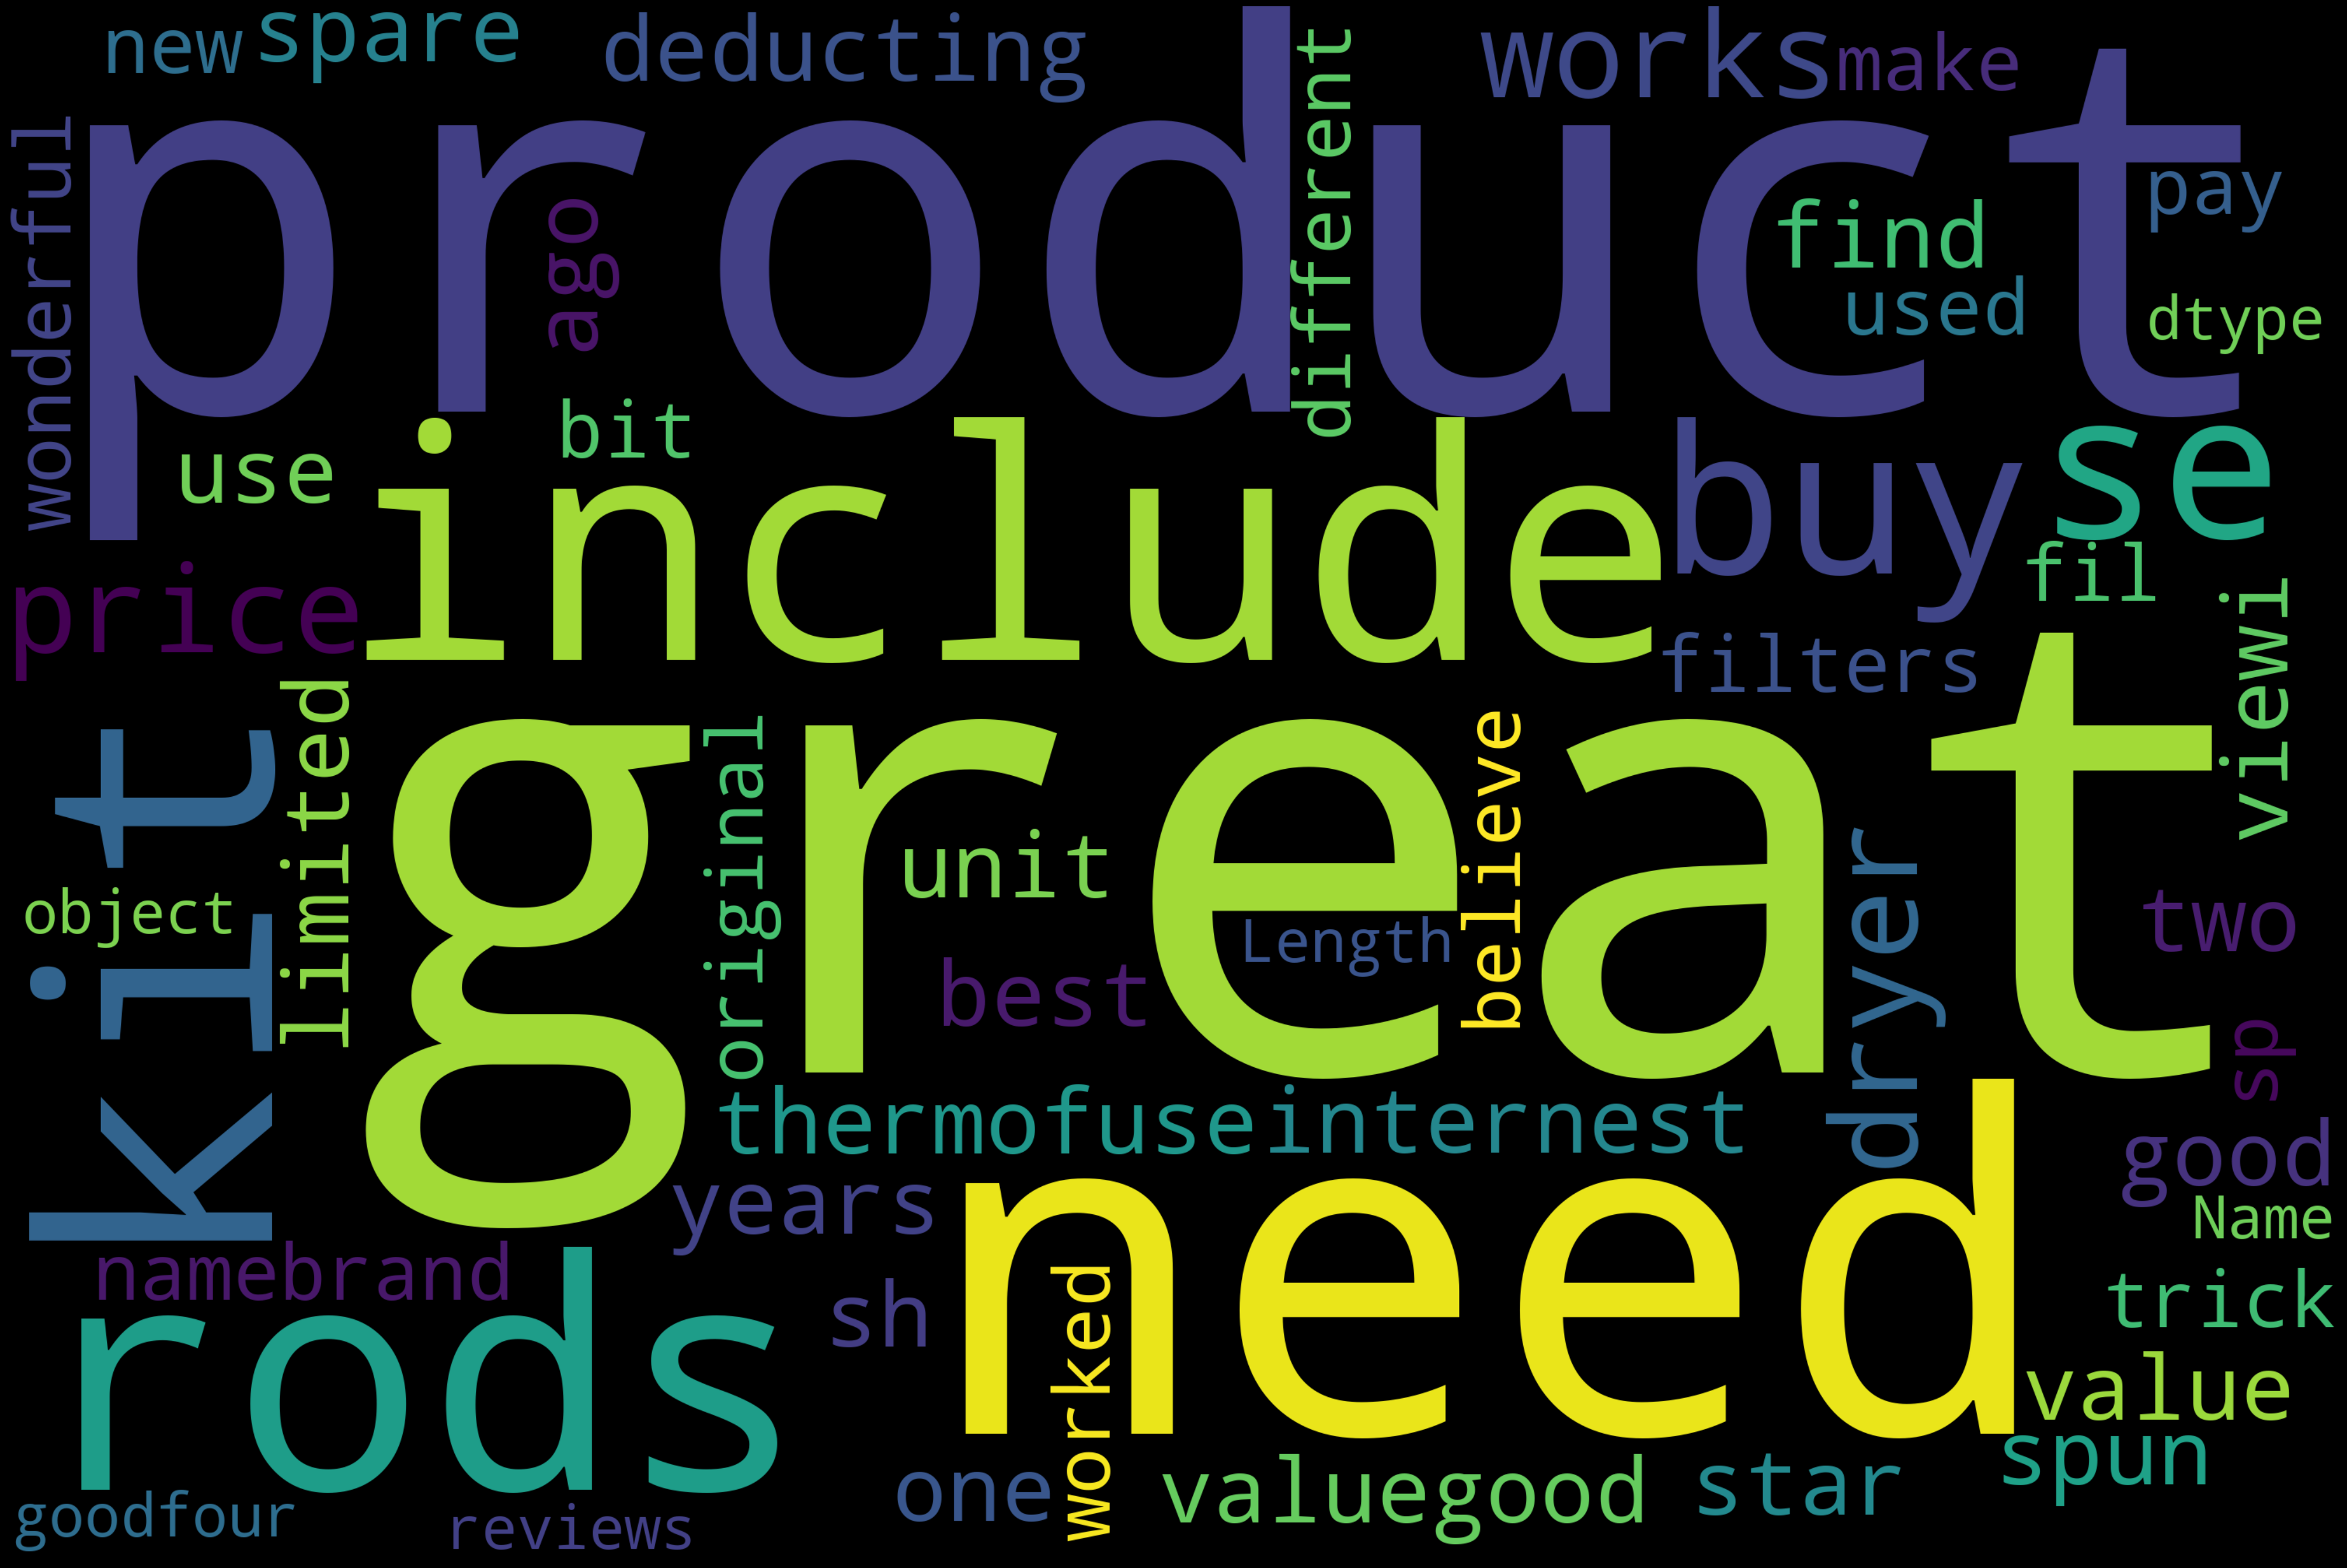

In [140]:
text = review_neu_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Wordcloud-Neutral reviews

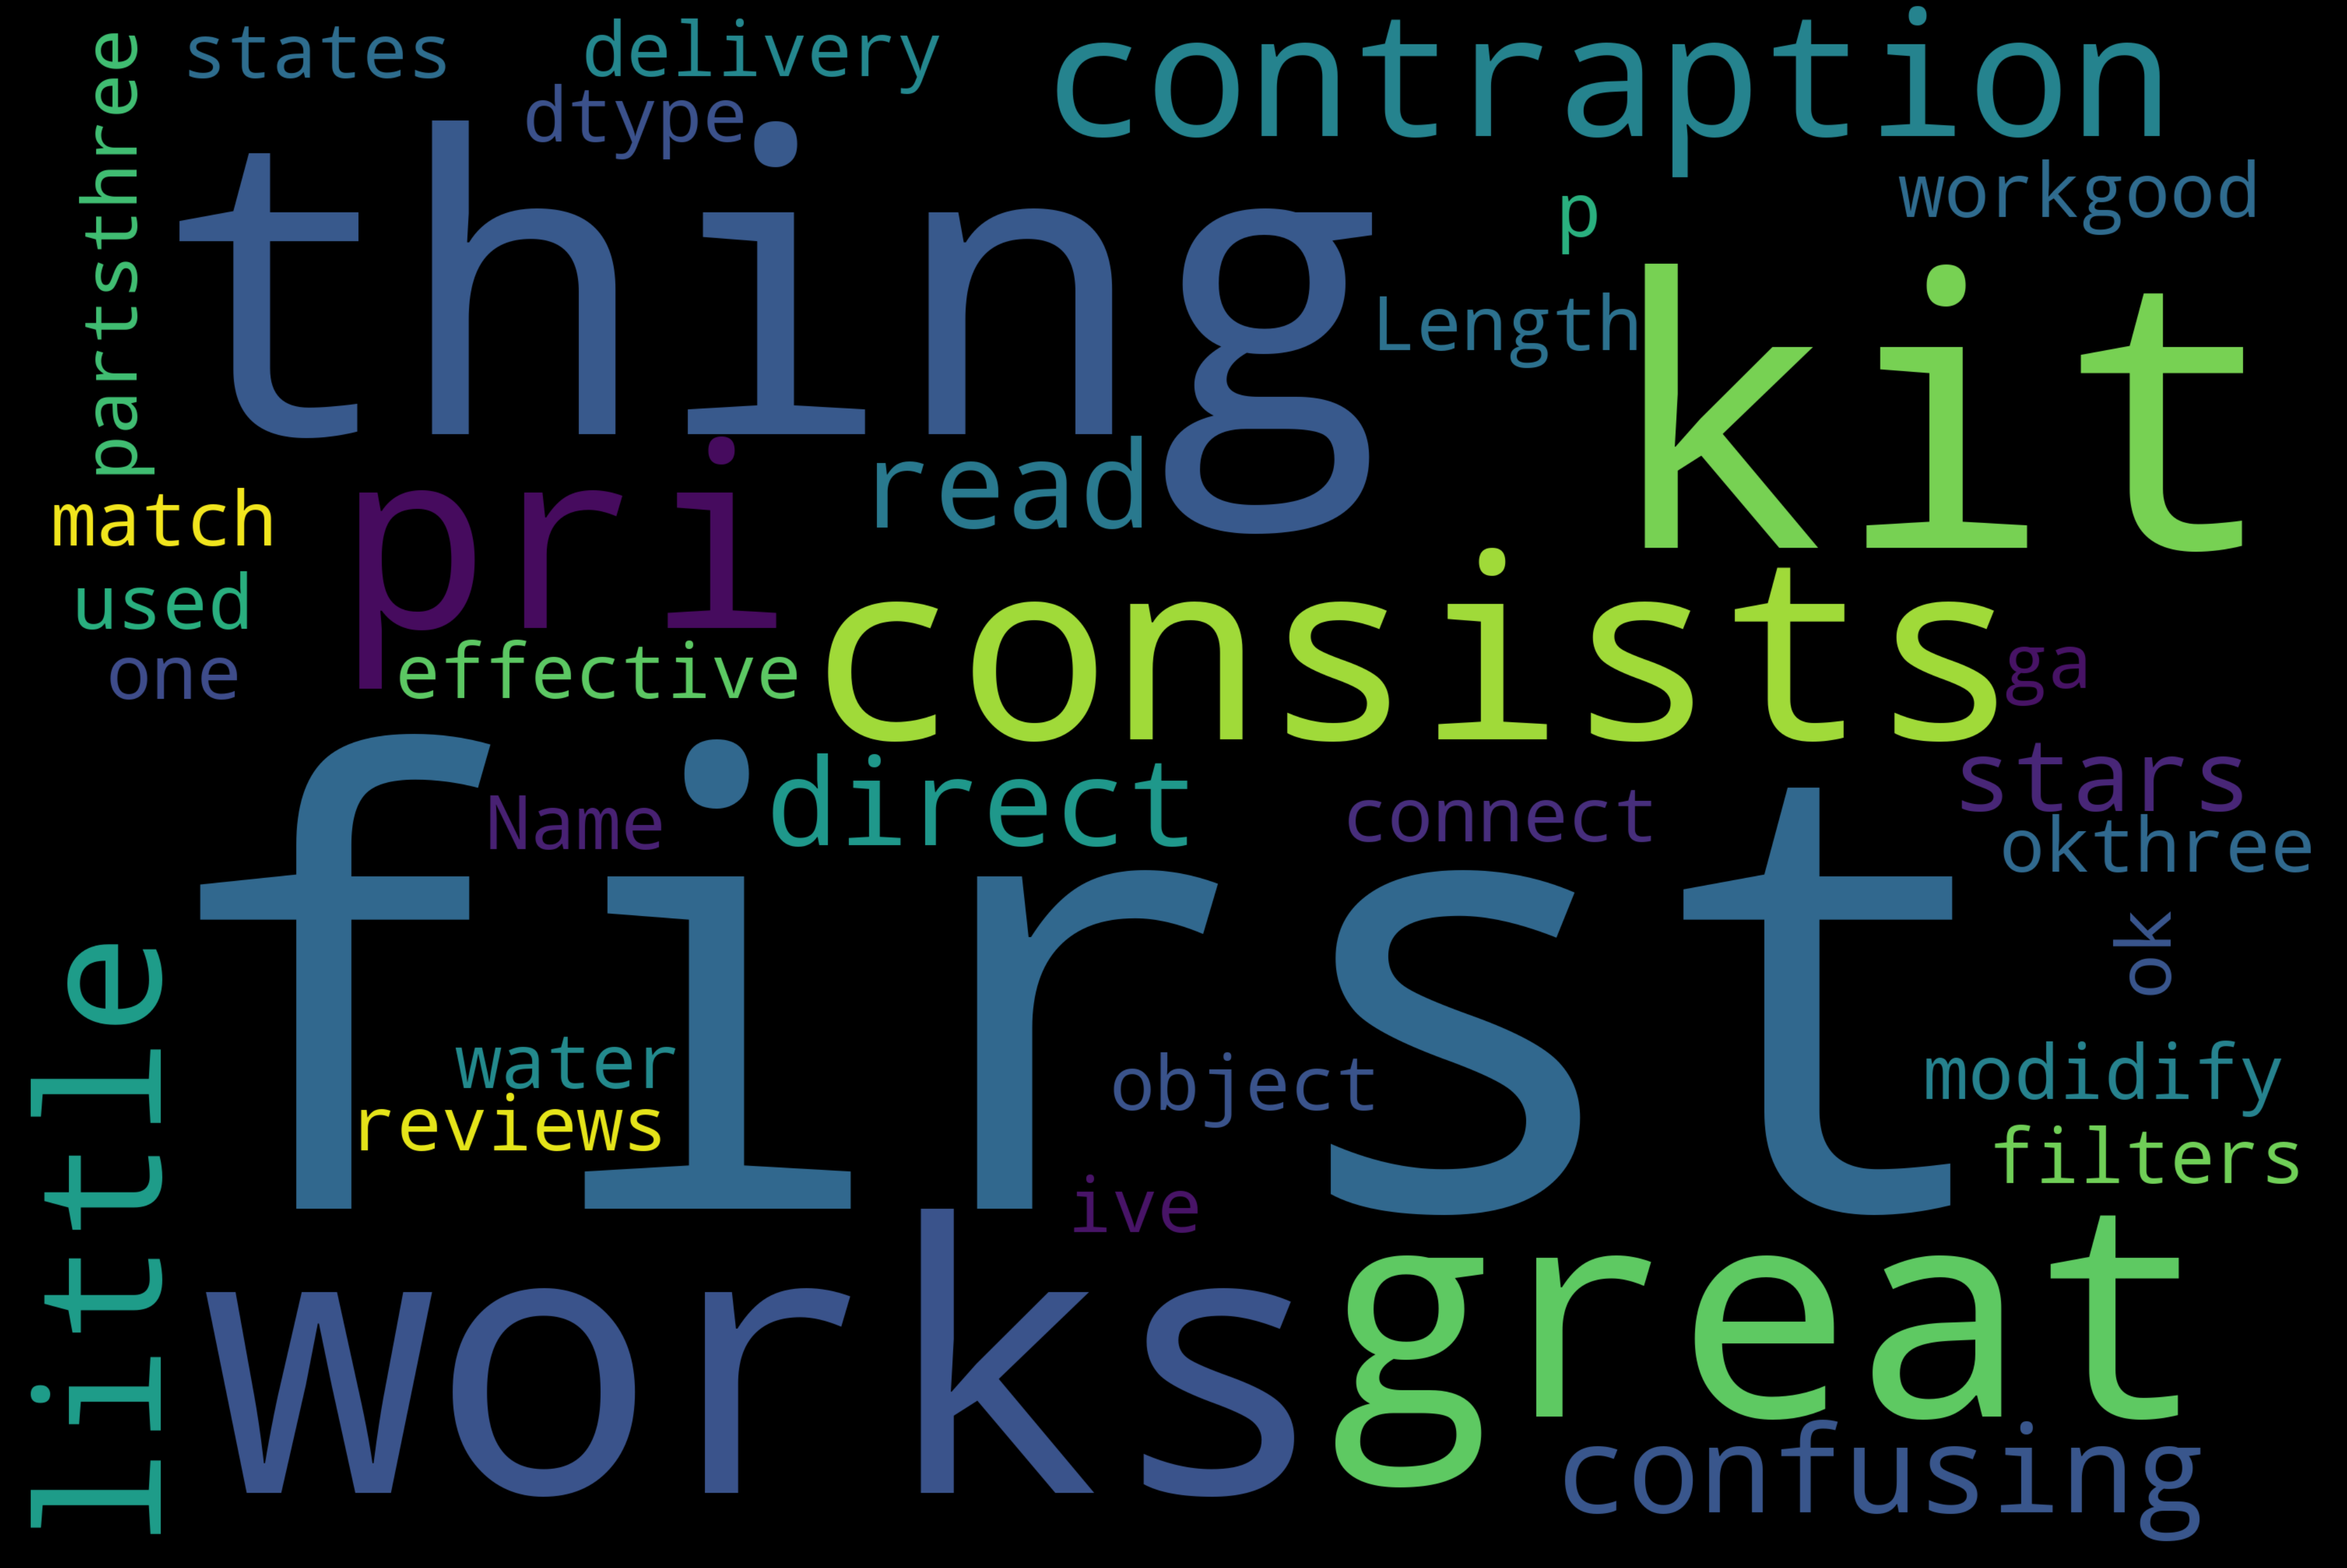

In [141]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Wordcloud-Neutral-Negative reviews

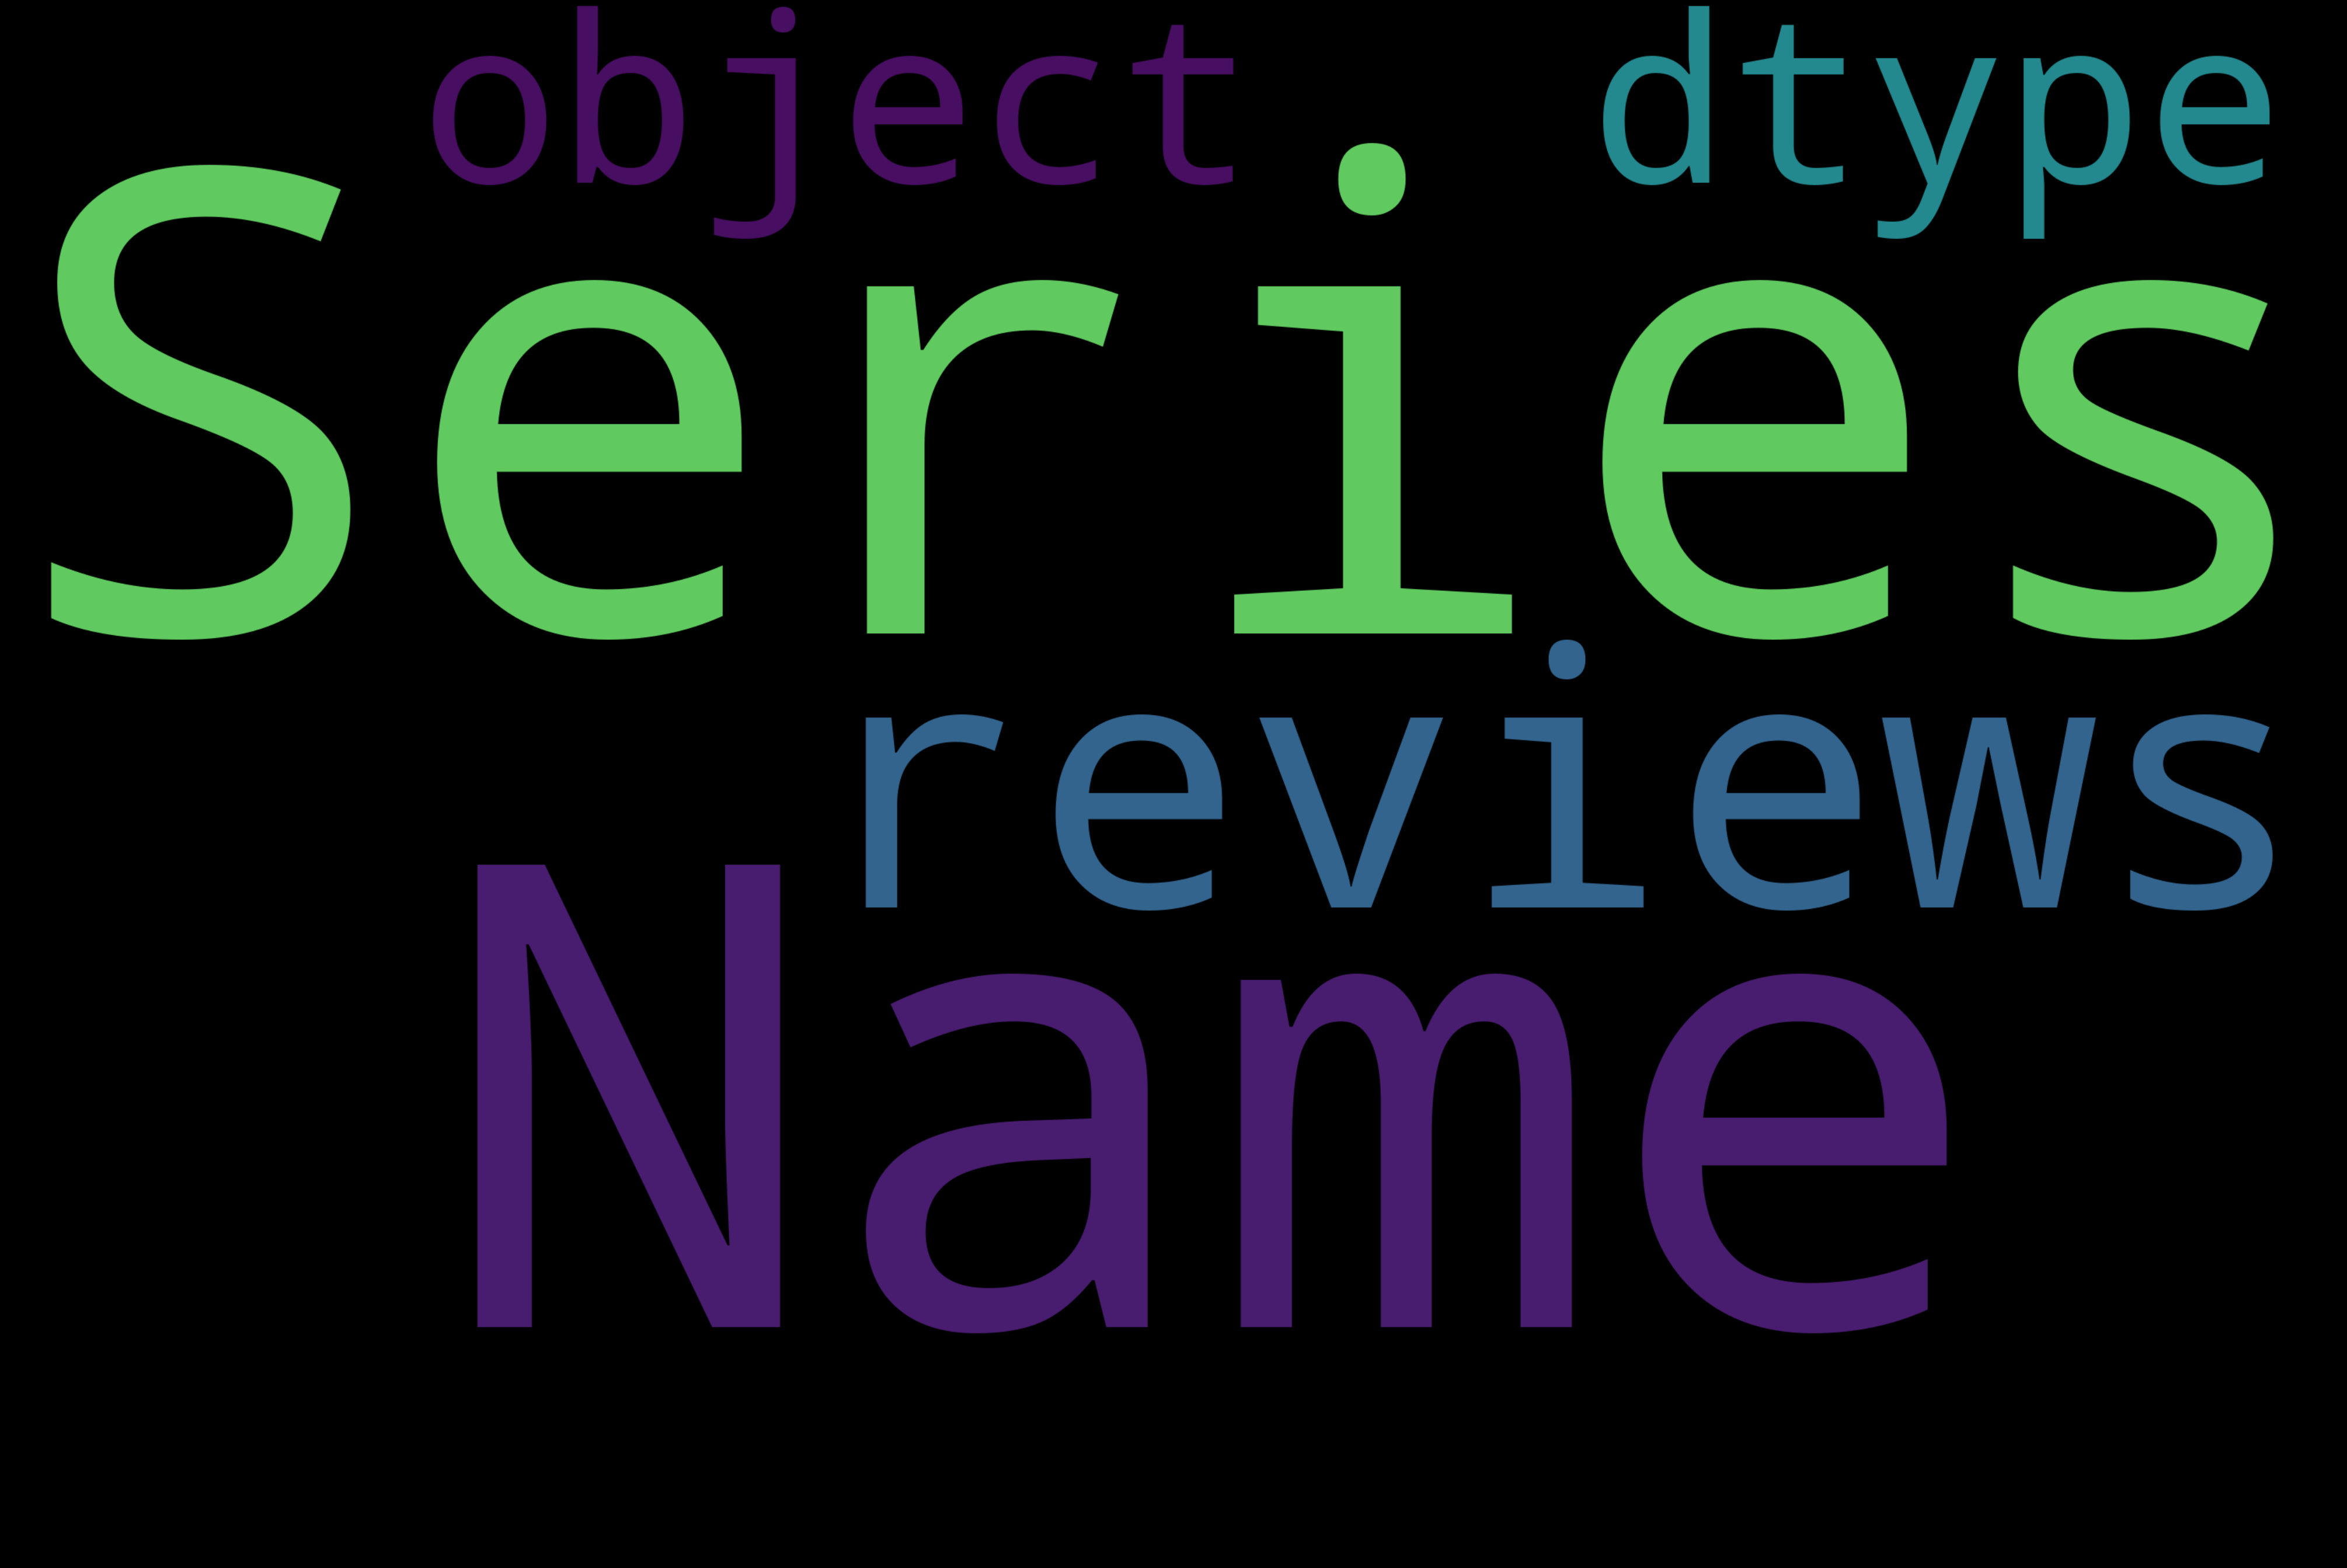

In [142]:
text = review_neu_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Wordcloud-Negative reviews

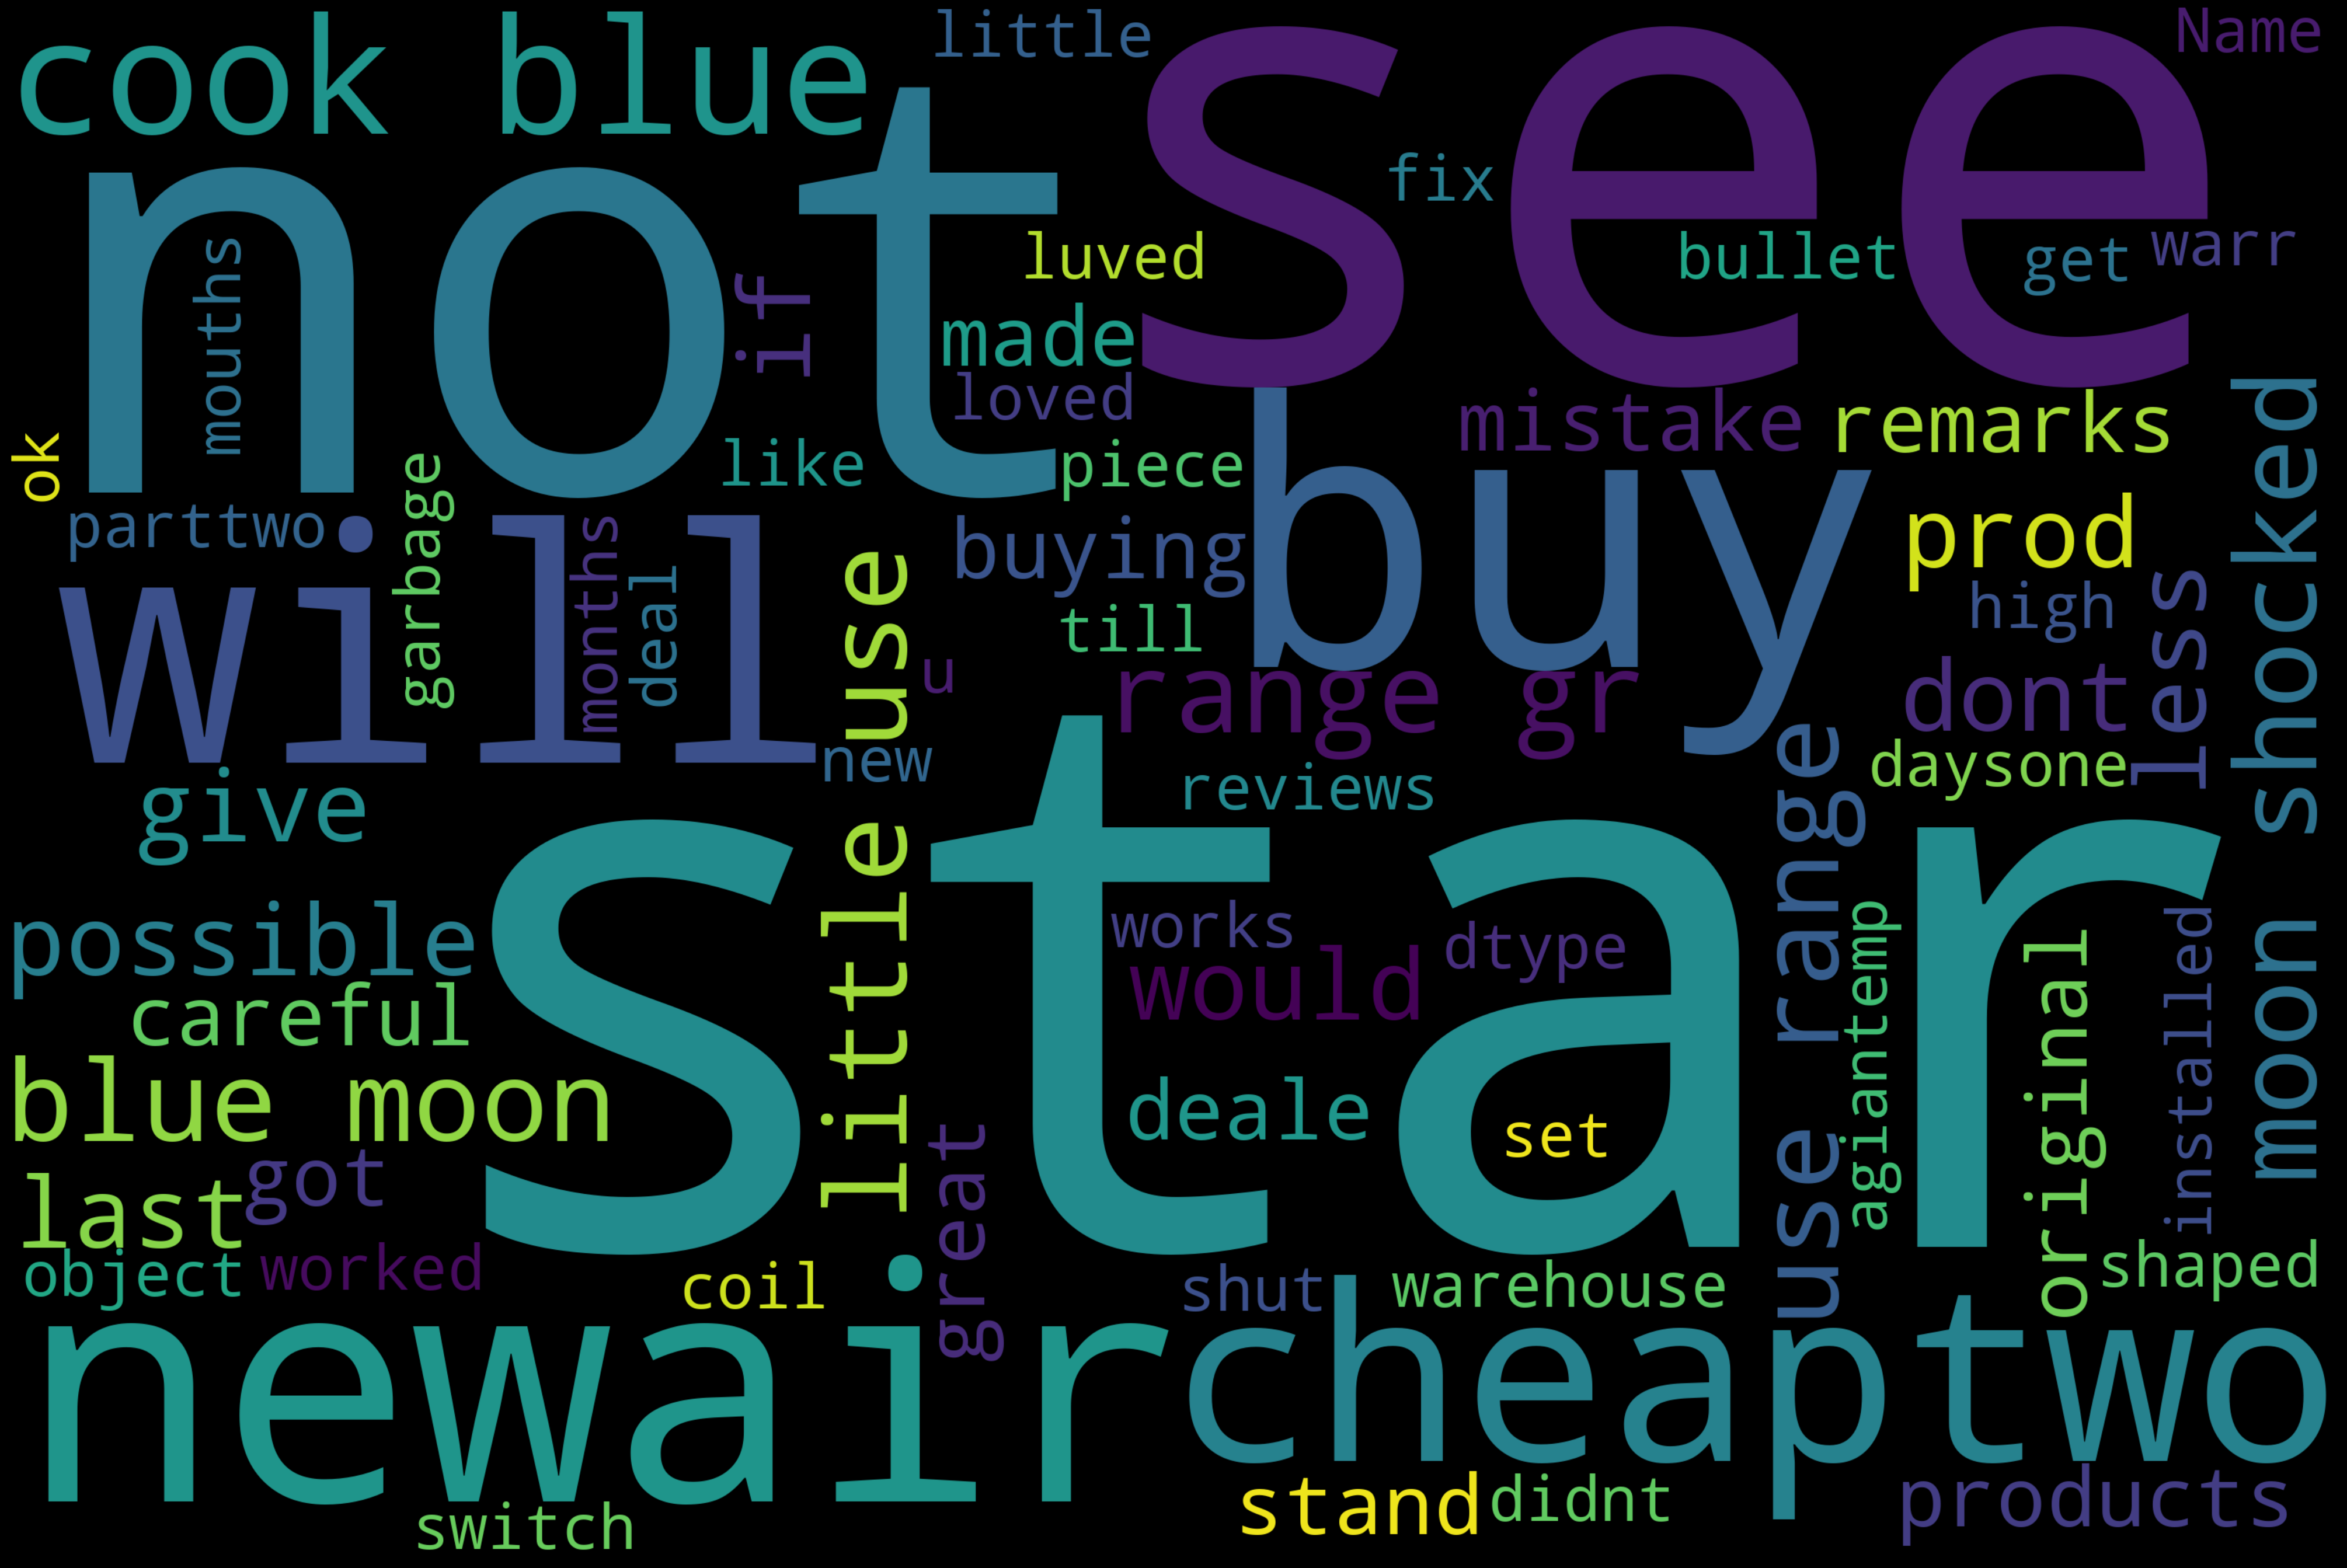

In [143]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Encoding target variable-sentiment

In [144]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([3, 2, 0, 1])

In [145]:
process_reviews['sentiment'].value_counts()

3    1612
1     421
2     222
0      22
Name: sentiment, dtype: int64

## Stemming the reviews
**Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. for example,**
* **Going->go**
* **Finally->fina**

**If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning. Simce it takes time. I'm using stemming**

In [146]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  like vent well something will keep house warme...
1                                good itemfive stars
2               fit new lg dryer perfectlyfive stars
3             good value electric dryersperfect size
4                 price delivery excellentfive stars

In [147]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)   

In [148]:
corpus[3]

'good valu electr dryersperfect size'

## TFIDF(Term Frequency — Inverse Document Frequency)

In [149]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [150]:
X.shape

(2277, 3388)

In [151]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

## Handling Imbalance target feature-SMOTE

In [152]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({3: 1612, 1: 421, 2: 222, 0: 22})
Resampled dataset shape Counter({3: 1612, 2: 1612, 0: 1612, 1: 1612})


## Train-test split(75:25)

In [153]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

# Model Building: Sentiment Analysis

In [155]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model selection

In [156]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9798071721153103
Decision Tree Test Accuracy: 0.986391915913131
KNN Test Accuracy: 0.977602596800371
SVC Test Accuracy: 0.9859513872787697
Naive Bayes Test Accuracy: 0.9124893732127676


## Logistic Regression with Hyperparameter tuning

In [157]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=2.559547922699533, random_state=0)
The mean accuracy of the model is: 0.9981389578163772


In [158]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


## Classification metrics

Confusion matrix, without normalization


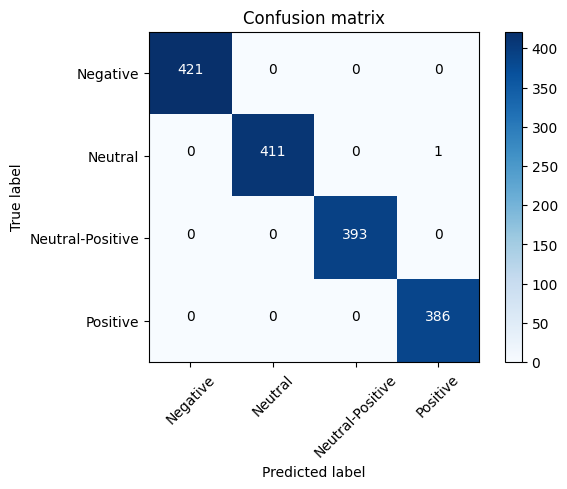

In [159]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Neutral-Positive','Positive'])

## ROC-AUC curve

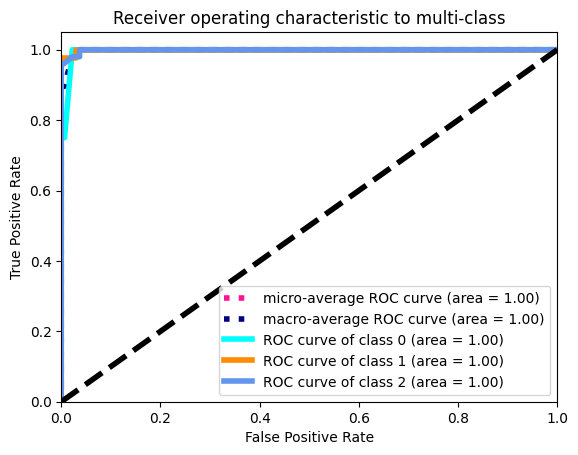

In [160]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()